##  Contexte et objectifs de l'étude.
### Bâtiment et énergie:
Le secteur du bâtiment représente 44 % de l’énergie consommée en France, loin devant le secteur des transports (31,3%). Chaque année, le secteur du bâtiment émet plus de 123 millions de tonnes de C02, ce qui en fait l’un des domaines clé dans la lutte contre le réchauffement climatique et la transition énergétique. Pour rendre le bâtiment plus économe en énergie, il faut rénover massivement l’existant et développer des normes plus strictes en termes de consommation d’énergie pour les bâtiments neufs. C’est l’objet de la politique de l’énergie dans les bâtiments. (https://www.ecologie.gouv.fr/energie-dans-batiments). Dans ce contexte de réduction drastique de la consommation énergétique des bâtiments et de la réduction tout aussi sévère des émissions de CO2, ainsi que du renchérissement du coût de l'énergie la ville a depuis plusieurs années procédé à des relevés de mesures.
Celles-ci sont couteuses. A partir de ces relevés, existe t-il des techniques fiables permettant d'estimer la consommation et les niveaux d'émissions pour des bâtiments non destinés à l'habitation et pour lesquels on n'a pas de mesures ?
Les relevés fournis concernent des données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)
Dans cette étude, on s'intéresse également à la mesure "Energy star score" pour la prédiction d'émissions. Mesure d'une approche fastidieuse et l'on cherchera à juger de son intérêt.
### Objectifs:
Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique. Dans cette partie, on s'intéresse à la prédiction de CO2 des bâtiments non dédiés à l'habitation.


## Import packages

In [633]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, f_regression

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor


## Chargement data

In [634]:
path= '/Users/olivierdebeyssac/Open Classrooms/Data_scientist/Projet_4_Anticipez_les_besoins_en_consommation_de_bâtiments/Data/2016_Building_Energy_Benchmarking.csv'
df = pd.read_csv (path, sep=',')

## Constitution d'un dataset avec qualité de données

### Exclusion variables

In [635]:
dropped_1 = ['DataYear', 'ZipCode', 'CouncilDistrictCode', 'OSEBuildingID','Comments', 'Outlier', 'DefaultData']

In [636]:
# Suppression colonnes "Comments" et "Outlier", ..., inutiles dans la suite des analyses.
df_temp = df.drop(dropped_1, axis=1)

In [637]:
# Numerical dataset
numerical_features = df_temp.loc[:, df_temp.dtypes != 'object']
print(numerical_features.shape)

(3376, 25)


Suppression des features numériques fortement corrélées entre elles.

In [638]:
dropped_2=['PropertyGFATotal','SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)',
          'NaturalGas(therms)']

# Suppression des features fortement corrélées entre elles.
numerical_features = numerical_features.loc[:,~numerical_features.columns.isin(dropped_2)]

Pour les colonnes numériques ayant des valeurs manquantes on peut remplacer par la valeurs médiane des features

### Remplacement valeurs numériques manquantes.

In [639]:
numerical_features.isna().mean()*100

Latitude                            0.000000
Longitude                           0.000000
YearBuilt                           0.000000
NumberofBuildings                   0.236967
NumberofFloors                      0.000000
PropertyGFAParking                  0.000000
PropertyGFABuilding(s)              0.000000
LargestPropertyUseTypeGFA           0.592417
SecondLargestPropertyUseTypeGFA    50.266588
ThirdLargestPropertyUseTypeGFA     82.345972
ENERGYSTARScore                    24.970379
SiteEUI(kBtu/sf)                    0.207346
SourceEUI(kBtu/sf)                  0.266588
SiteEnergyUse(kBtu)                 0.148104
SteamUse(kBtu)                      0.266588
Electricity(kBtu)                   0.266588
NaturalGas(kBtu)                    0.266588
TotalGHGEmissions                   0.266588
GHGEmissionsIntensity               0.266588
dtype: float64

In [640]:
numerical_features = numerical_features.fillna(numerical_features.median())

### Construction dataset X_cat (valeurs catégorielles).

In [641]:
# Exclusion des features de type catégoriel n'ayant pas d'interêt.
to_be_excluded_cat = ['City', 'State', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes',
                 'YearsENERGYSTARCertified', 'PropertyName', 'Address', 'ComplianceStatus']
condition_1 = (df_temp.columns.isin(to_be_excluded_cat))

df_temp = df_temp.loc[:,condition_1==False]
X_cat = df_temp.select_dtypes(object)

### Occurences des catégories.

Pour plusieurs variables, on a des catégories pour lesquelles on a un seul échantillon. Ceci posera problème lors de l'étape "train_test_split". En effet pour la catégorie pour laquelle on a une seule valeur, on ne pourra pas dispatcher cette catégorie entre "train" et "test". On exclut ces catégories pour ne pas provoquer d'erreur par la suite.
- On renomme numerical_features en X_num
- On concatène X_num et X_cat ==> X
- On exclut les lignes avec occurence=1

In [642]:
X_num = numerical_features
X = pd.concat([X_num, X_cat], axis=1)

In [643]:
# Vérification des valeurs des features X_cat
def check(df):
    l_pos = []
    
    for i in range(len(df.columns)):
        col_name = df.columns[i]
        
        s = df.iloc[:,i]
        cond = (s.dtypes == object)
        
        if cond:

            f = s.value_counts() # comptage des fréquences d'apparition        
            v = f[f<=1] # ensemble des valeurs avec fréquence <=1
        
            for j in range(len(v.index)):
                e = v.index[j] # chaine de caractère correspondant à l'index de la série
                        
                pos_df = df.loc[df[col_name] == e].index # chercher la chaine de caractére dans df et obtenir l'index
                
                pos_df = list(pos_df)
            
                l_pos.append(pos_df)
        
            
    return l_pos


In [644]:
list_of_list = check(X)

In [645]:
# Exclusion des lignes portant l'index indiqué dans "list_of_list".
def supp_rows (df, liste):
    pos = [val for sublist in list_of_list for val in sublist]
    df = df.drop(pos, axis=0)
    
    return df
    

In [646]:
# Exclusion des lignes avec occurence=1.

X = supp_rows(X, list_of_list)


In [647]:
# Reset de l'index

X.reset_index(drop=True,inplace=True)

In [648]:
X.isnull().mean()*100

Latitude                            0.000000
Longitude                           0.000000
YearBuilt                           0.000000
NumberofBuildings                   0.000000
NumberofFloors                      0.000000
PropertyGFAParking                  0.000000
PropertyGFABuilding(s)              0.000000
LargestPropertyUseTypeGFA           0.000000
SecondLargestPropertyUseTypeGFA     0.000000
ThirdLargestPropertyUseTypeGFA      0.000000
ENERGYSTARScore                     0.000000
SiteEUI(kBtu/sf)                    0.000000
SourceEUI(kBtu/sf)                  0.000000
SiteEnergyUse(kBtu)                 0.000000
SteamUse(kBtu)                      0.000000
Electricity(kBtu)                   0.000000
NaturalGas(kBtu)                    0.000000
TotalGHGEmissions                   0.000000
GHGEmissionsIntensity               0.000000
BuildingType                        0.000000
PrimaryPropertyType                 0.000000
Neighborhood                        0.000000
LargestPro

In [649]:
X.drop('ThirdLargestPropertyUseType', axis=1,inplace=True)

## Modélisation, SVR et selectKBest

### Choix label

Quelle label faut il choisir pour obtenir des prédictions qui répondent à l'objectif fixé ?

In [650]:
label = 'GHGEmissionsIntensity'

In [651]:
y = X[label]

In [652]:
X_wo_Y = X.drop(label, axis=1)

### Vérification valeurs manquantes label, dimensions

In [653]:
y_nan = y.loc[y.isnull() == True]

In [654]:
y_nan.index

Int64Index([], dtype='int64')

In [655]:
print("Dimensions sur X: {}".format(X_wo_Y.shape))
print("Dimensions sur y: {}".format(y.shape))

Dimensions sur X: (3345, 23)
Dimensions sur y: (3345,)


### Définition des features

In [656]:
# Distinguer les formats "Num" et "Cat" pour X
numerical_features = X_wo_Y.select_dtypes(include=['float64']).columns.tolist()
categorical_features = X_wo_Y.select_dtypes(include="object").columns.tolist()

### Construction des pipelines "Num" et "Cat"

In [657]:
# Pipeline numérique features

numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                   RobustScaler())


In [658]:
# Pipeline categorical features

categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                     OneHotEncoder(categories='auto', 
                                                   handle_unknown='infrequent_if_exist',
                                                   sparse_output=False))


### Définition des transformations

In [659]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                         (categorical_pipeline, categorical_features))

### Transformations sur y

In [660]:
robust_scaler = RobustScaler()
y_reshaped = y.values.reshape(-1,1)
y_scaled_T = robust_scaler.fit_transform(y_reshaped)
print("Dimensions sur y: {}".format(y_scaled_T.shape))

Dimensions sur y: (3345, 1)


### Split dataset

In [661]:
X_train, X_test,y_train ,y_test = train_test_split(X_wo_Y, y_scaled_T, test_size=0.20, random_state=0)

### Construction de la pipeline transformations + selection features + estimateur

In [662]:
selector = SelectKBest(f_regression,k=10)

estimator = SVR(kernel='rbf')

In [663]:
pipe = make_pipeline(preprocessor, selector)

In [664]:
model = make_pipeline(pipe, estimator)

In [665]:
model.fit(X_train, y_train)

/Users/olivierdebeyssac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/olivierdebeyssac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   ['Latitude',
                                                                    'Longitude',
                                                                    'NumberofBuildings',
                                                                    'LargestPropertyUseTypeGFA',
                                                                    'SecondLargestPropertyUseTypeGFA',
                                                                    'ThirdLargestPropertyUseTypeGFA'...
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                  sparse_output=False))]),
                                                                   ['BuildingType',
                                                                    'PrimaryPropertyType',
                                                                    'Neighborhood',
                                                                    'LargestPropertyUseType',
                                                                    'SecondLargestPropertyUseType'])])),
                                 ('selectkbest',
                                  SelectKBest(score_func=<function f_regression at 0x7f9e241cd0d0>))])),
                ('svr', SVR())])

### Score

In [666]:
model.score(X_test, y_test)

0.5776175063945691

In [667]:
pipe.get_feature_names_out(input_features=X_wo_Y.columns)

array(['pipeline-1__SiteEUI(kBtu/sf)', 'pipeline-1__SourceEUI(kBtu/sf)',
       'pipeline-1__SiteEnergyUse(kBtu)', 'pipeline-1__NaturalGas(kBtu)',
       'pipeline-1__TotalGHGEmissions',
       'pipeline-2__PrimaryPropertyType_Laboratory',
       'pipeline-2__PrimaryPropertyType_Supermarket / Grocery Store',
       'pipeline-2__LargestPropertyUseType_Multifamily Housing',
       'pipeline-2__LargestPropertyUseType_Restaurant',
       'pipeline-2__LargestPropertyUseType_Supermarket/Grocery Store'],
      dtype=object)

On voit que Support Vector regressor avec les features sélectionnées par KBest n'est pas performant. On va se tourner vers une méthode de Bagging avec Random Forest.

## Modélisation, Random Forest.

### Instanciation modèle

In [668]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0)

In [669]:
pipe_rf = make_pipeline(preprocessor, rf)

### Entrainement du modèle.

In [670]:
pipe_rf.fit(X_train, y_train.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore',
                                                   'SiteEUI(...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=0))])

### Score, prédiction.

In [671]:
pipe_rf.score(X_test, y_test.ravel())

0.6705059239564557

Peut on améliorer le modéle ?

In [672]:
y_rf_pred_reg = pipe_rf.predict(X_test)

In [673]:
print(y_rf_pred_reg.shape, y_test.shape)

(669,) (669, 1)


In [674]:
y_test = y_test.reshape(669,)
print(y_test.shape)

(669,)


### Optimisaiton hyperparamètres du modèle.

Sans optimisation, Random Forest ne parvient pas à retranscrire la variance du dataset. On essaye une optimisation de deux paramètres, n_estimator, et max_depth.

In [675]:
pipe_rf_opt = make_pipeline(preprocessor, RandomForestRegressor())

In [676]:
pipe_rf_opt.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('robustscaler',
                                                     RobustScaler())]),
                                    ['Latitude', 'Longitude', 'NumberofBuildings',
                                     'LargestPropertyUseTypeGFA',
                                     'SecondLargestPropertyUseTypeGFA',
                                     'ThirdLargestPropertyUseTypeGFA',
                                     'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                                     'SourceEUI(kBtu/sf)', 'SiteE...
                                     'SteamUse(kBtu)', 'Electricity(kBtu)',
                                     'NaturalGas(kBtu)', 'TotalGHGEmissions']),
        

In [677]:
param_grid={'randomforestregressor__max_depth':[2, 3, 4, 5, 6, 7, 8], 
            'randomforestregressor__n_estimators':[200,400,600,800, 1000]}

In [678]:
GridSearchCV(pipe_rf_opt, param_grid, cv=5)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'NumberofBuildings',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA'...
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [2, 3, 4, 5, 6, 7,
                                                              8],
                         'randomforestregressor__n_estimators': [200, 400, 600,
                                                                 800, 1000]})

In [679]:
grid = GridSearchCV(pipe_rf_opt, param_grid, cv=5)

In [680]:
grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'NumberofBuildings',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA'...
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [2, 3, 4, 5, 6, 7,
                                                              8],
                         'randomforestregressor__n_estimators': [200, 400, 600,
                                                                 800, 1000]})

In [681]:
grid.cv_results_

{'mean_fit_time': array([ 0.70108056,  1.39296803,  2.0665194 ,  2.758464  ,  3.43768778,
         0.96386633,  1.90455709,  2.84961271,  3.79271035,  4.7384798 ,
         1.20540118,  2.41245995,  3.59853268,  4.79616041,  5.98892131,
         1.44244661,  2.88433504,  4.33057723,  5.76446357,  7.20866499,
         1.68716602,  3.34807134,  5.0476418 ,  6.69336662,  8.42395339,
         1.92093177,  3.84236455,  5.71266894,  7.6570075 ,  9.58489585,
         2.1866117 ,  4.3993124 ,  6.5456902 ,  8.55073261, 10.7821146 ]),
 'std_fit_time': array([0.00757923, 0.01324572, 0.00571075, 0.01064429, 0.0186631 ,
        0.01151718, 0.0048029 , 0.019426  , 0.02108895, 0.02544181,
        0.00329127, 0.0215998 , 0.00902958, 0.02385119, 0.01056377,
        0.0028087 , 0.00908946, 0.01345   , 0.03705685, 0.03117898,
        0.01540338, 0.00726122, 0.04451947, 0.01314036, 0.07956826,
        0.01811735, 0.0303541 , 0.01955104, 0.08226549, 0.08880367,
        0.02106854, 0.0462877 , 0.01203667, 0.

In [682]:
grid.best_params_

{'randomforestregressor__max_depth': 8,
 'randomforestregressor__n_estimators': 200}

In [683]:
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore',
                                                   'SiteEUI(...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=8, n_estimators=200))])

### Score

In [684]:
grid.score(X_test, y_test)

0.6619087471551575

In [685]:
y_rf_pred_opt = grid.predict(X_test)
print(y_pred.shape)
print(y_test.shape)

(669,)
(669,)


In [686]:
d_= {'actuals_rf': y_test, 'pred_rf_reg': y_rf_pred_reg,'pred_rf_opt': y_rf_pred_opt}
l_keys = list(d_.keys())
print(l_keys)

['actuals_rf', 'pred_rf_reg', 'pred_rf_opt']


In [687]:
df_rf = pd.DataFrame(d_)

In [688]:
df_rf.head()

,actuals_rf,pred_rf_reg,pred_rf_opt
0,0.513043,0.870696,0.941216
1,0.686957,0.835852,0.889932
2,0.313043,0.147913,0.181364
3,-0.365217,-0.347522,-0.361179
4,0.521739,3.015600,3.124024


In [689]:
# Visualisation

def vis(df_rf):
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    sns.scatterplot(data=df_rf, x=l_keys[0], y=l_keys[1], label='non opt.')
    
    sns.scatterplot(data=df_rf, x=l_keys[0], y=l_keys[2], label='opt.')
    
    plt.legend()
    plt.xticks(fontsize=7, rotation=45)
    plt.yticks(fontsize=7, rotation=45)
    plt.title('RF - act. vs. pred - GHGEmissionsIntensity (avt/ap opt)')
    plt.show()
    
    return


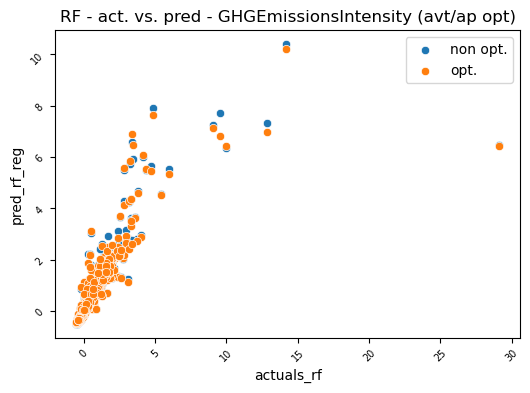

In [690]:
vis(df_rf)

### Classement des variables (Feature importance)

In [691]:
pipe_rf_opt.fit(X_train, y_train)

/Users/olivierdebeyssac/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore',
                                                   'SiteEUI(...
                                                   'TotalGHGEmissions']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [692]:
print(pipe_rf_opt[:-1].get_feature_names_out())
print(len(pipe_rf_opt[:-1].get_feature_names_out()))

['pipeline-1__Latitude' 'pipeline-1__Longitude'
 'pipeline-1__NumberofBuildings' 'pipeline-1__LargestPropertyUseTypeGFA'
 'pipeline-1__SecondLargestPropertyUseTypeGFA'
 'pipeline-1__ThirdLargestPropertyUseTypeGFA'
 'pipeline-1__ENERGYSTARScore' 'pipeline-1__SiteEUI(kBtu/sf)'
 'pipeline-1__SourceEUI(kBtu/sf)' 'pipeline-1__SiteEnergyUse(kBtu)'
 'pipeline-1__SteamUse(kBtu)' 'pipeline-1__Electricity(kBtu)'
 'pipeline-1__NaturalGas(kBtu)' 'pipeline-1__TotalGHGEmissions'
 'pipeline-2__BuildingType_Campus'
 'pipeline-2__BuildingType_Multifamily HR (10+)'
 'pipeline-2__BuildingType_Multifamily LR (1-4)'
 'pipeline-2__BuildingType_Multifamily MR (5-9)'
 'pipeline-2__BuildingType_NonResidential'
 'pipeline-2__BuildingType_Nonresidential COS'
 'pipeline-2__BuildingType_SPS-District K-12'
 'pipeline-2__PrimaryPropertyType_Distribution Center'
 'pipeline-2__PrimaryPropertyType_High-Rise Multifamily'
 'pipeline-2__PrimaryPropertyType_Hospital'
 'pipeline-2__PrimaryPropertyType_Hotel'
 'pipeline-2__P

In [693]:
pipe_rf_opt[-1:].named_steps['randomforestregressor'].feature_importances_
print(pipe_rf_opt[-1:].named_steps['randomforestregressor'].feature_importances_)
print(pipe_rf_opt[-1:].named_steps['randomforestregressor'].feature_importances_.shape)

[7.44565793e-03 7.15867451e-03 1.04242048e-02 2.64495582e-02
 1.26197320e-02 1.58071678e-03 5.30873505e-03 5.64495190e-01
 1.92482668e-02 5.84319895e-03 2.44512842e-02 4.32044922e-02
 1.71509848e-01 6.99327318e-02 1.17131465e-03 3.24060043e-05
 5.30983415e-04 7.25851585e-05 4.19807219e-04 4.40741658e-04
 8.05480703e-06 4.07940361e-06 2.30738683e-05 6.34082773e-04
 1.27800861e-04 7.12289216e-04 9.25312099e-04 1.59016472e-04
 5.43876271e-04 8.42819083e-05 9.72655575e-05 4.05031680e-04
 1.30219066e-05 5.39370130e-04 8.57769094e-06 4.24719383e-05
 1.59254082e-04 6.98243884e-05 1.63814965e-06 9.76470923e-05
 1.96679159e-04 6.91285365e-04 5.92589563e-05 2.09749429e-05
 2.62253759e-05 3.12323221e-05 2.75974136e-07 9.94590504e-05
 1.92458187e-05 9.67800957e-05 1.07713358e-03 2.52710338e-05
 5.70954614e-04 2.60706682e-04 1.13842646e-03 6.05901346e-04
 6.49187312e-04 3.56713541e-04 9.86984387e-05 3.33994893e-05
 1.46450676e-06 1.42816399e-04 2.52368952e-04 8.92483864e-07
 3.89837197e-06 5.911745

In [694]:
def importance(names,arr):
    df = pd.DataFrame(data=pipe_rf.named_steps['randomforestregressor'].feature_importances_,
                     index=preprocessor.get_feature_names_out())
    df.reset_index(inplace=True)
    df.rename(columns={0: 'values', 'index':'categories'}, inplace=True)
    df['features']=0
    df['features'].astype(str)
    
    df['features']=df['categories'].apply(lambda x: x.split('__')[1])
    df['features']=df['features'].apply(lambda x: x.split('_')[0])
    
    df = df.groupby(['features','categories'], as_index=False).sum()
    
    df['log_values'] = np.log(df['values'])
    df.sort_values(by=['log_values'], ascending=True,inplace=True)
    
    return df

In [695]:
df = importance(pipe_rf_opt[:-1].get_feature_names_out(),
                pipe_rf_opt[-1:].named_steps['randomforestregressor'].feature_importances_)

In [696]:
df.head()

,features,categories,values,log_values
103,SecondLargestPropertyUseType,pipeline-2__SecondLargestPropertyUseType_Autom...,1.951157e-08,-17.752258
131,SecondLargestPropertyUseType,pipeline-2__SecondLargestPropertyUseType_Refri...,5.889266e-08,-16.647549
37,LargestPropertyUseType,pipeline-2__LargestPropertyUseType_Other - Uti...,7.677859e-08,-16.382340
40,LargestPropertyUseType,pipeline-2__LargestPropertyUseType_Performing ...,8.001731e-08,-16.341023
41,LargestPropertyUseType,pipeline-2__LargestPropertyUseType_Pre-school/...,1.717872e-07,-15.577009


In [697]:
def vis_importance(df):

    fig, axes = plt.subplots(1,1, figsize=(12, 5))
    sns.barplot(data=df, x='features',y='log_values')
    plt.xticks(fontsize=6, rotation=45)
    plt.title('Featues importance - CO2')
    plt.show()
    return

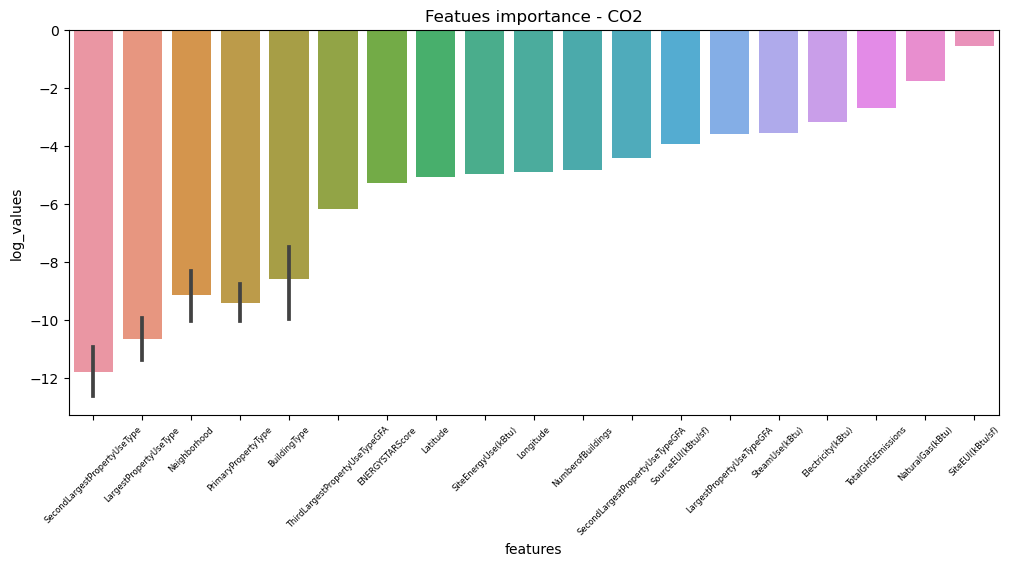

In [698]:
vis_importance(df)

## Modélisation, Adaboost

### Instanciation du modèle.

In [699]:
ada = AdaBoostRegressor(n_estimators = 1000, random_state = 0)

In [700]:
pipe_ada = make_pipeline(preprocessor, ada)

### Entrainement du modèle.

In [701]:
ada_fitted = pipe_ada.fit(X_train, y_train.ravel())

### Score.

In [702]:
ada_fitted.score(X_test, y_test)

0.245685056559518

De la même façon, il faut trouver les paramètres permettant d'améliorer la performance du modèle.

### Optimisation

In [703]:
AdaBoostRegressor().get_params()

{'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

In [704]:
pipe_ada = make_pipeline(preprocessor,AdaBoostRegressor())

In [705]:
pipe_ada.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('robustscaler',
                                                     RobustScaler())]),
                                    ['Latitude', 'Longitude', 'NumberofBuildings',
                                     'LargestPropertyUseTypeGFA',
                                     'SecondLargestPropertyUseTypeGFA',
                                     'ThirdLargestPropertyUseTypeGFA',
                                     'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                                     'SourceEUI(kBtu/sf)', 'SiteE...
                                     'SteamUse(kBtu)', 'Electricity(kBtu)',
                                     'NaturalGas(kBtu)', 'TotalGHGEmissions']),
        

In [706]:
param_grid_ada={'adaboostregressor__n_estimators':[100, 200, 400, 600, 800, 1000]}

In [707]:
grid_ada = GridSearchCV(pipe_ada, param_grid_ada, cv=5)

In [708]:
grid_ada.fit(X_train, y_train.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'NumberofBuildings',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA'...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType'])])),
                                       ('adaboostregressor',
                                        AdaBoostRegressor())]),
             param_grid={'adaboostregressor__n_estimators': [100, 200, 400, 600,
                                                             800, 1000]})

In [709]:
grid_ada.score(X_test, y_test.ravel())

0.389088936148418

In [710]:
grid.cv_results_

{'mean_fit_time': array([ 0.70108056,  1.39296803,  2.0665194 ,  2.758464  ,  3.43768778,
         0.96386633,  1.90455709,  2.84961271,  3.79271035,  4.7384798 ,
         1.20540118,  2.41245995,  3.59853268,  4.79616041,  5.98892131,
         1.44244661,  2.88433504,  4.33057723,  5.76446357,  7.20866499,
         1.68716602,  3.34807134,  5.0476418 ,  6.69336662,  8.42395339,
         1.92093177,  3.84236455,  5.71266894,  7.6570075 ,  9.58489585,
         2.1866117 ,  4.3993124 ,  6.5456902 ,  8.55073261, 10.7821146 ]),
 'std_fit_time': array([0.00757923, 0.01324572, 0.00571075, 0.01064429, 0.0186631 ,
        0.01151718, 0.0048029 , 0.019426  , 0.02108895, 0.02544181,
        0.00329127, 0.0215998 , 0.00902958, 0.02385119, 0.01056377,
        0.0028087 , 0.00908946, 0.01345   , 0.03705685, 0.03117898,
        0.01540338, 0.00726122, 0.04451947, 0.01314036, 0.07956826,
        0.01811735, 0.0303541 , 0.01955104, 0.08226549, 0.08880367,
        0.02106854, 0.0462877 , 0.01203667, 0.

In [711]:
grid_ada.best_params_

{'adaboostregressor__n_estimators': 100}

In [712]:
pipe_ada_opt = make_pipeline(preprocessor,AdaBoostRegressor(n_estimators=100))

In [713]:
pipe_ada_opt.fit(X_train, y_train.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore',
                                                   'SiteEUI(...
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType'])])),
                ('adaboostregressor', AdaBoostRegressor(n_estimators=100))])

In [714]:
pipe_ada_opt.score(X_test, y_test.ravel())

0.37377435936543046

## Conclusion.

Pour l'analyse de prédiciton des émissions de CO2, le modèle à privilégier est Random Forest. AdaBoost n'est pas performant dans ce contexte d'analyse.

## Analyse avec RF pour le non résidentiel

### Réduction dataset, exclusion des bâtiments destinés à l'habitation.

In [715]:
# Nomenclature des bâtiments à usage non habitation (à partir de variable "BuildingType").
non_residential = ['NonResidential', 'Nonresidential COS','SPS-District K-12', 'Campus','Nonresidential WA']


In [716]:
condition = (X['BuildingType'].isin(non_residential) == True)
X_nr = X[condition]

In [717]:
X_nr['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [718]:
X_nr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642 entries, 0 to 3344
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Latitude                         1642 non-null   float64
 1   Longitude                        1642 non-null   float64
 2   YearBuilt                        1642 non-null   int64  
 3   NumberofBuildings                1642 non-null   float64
 4   NumberofFloors                   1642 non-null   int64  
 5   PropertyGFAParking               1642 non-null   int64  
 6   PropertyGFABuilding(s)           1642 non-null   int64  
 7   LargestPropertyUseTypeGFA        1642 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  1642 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   1642 non-null   float64
 10  ENERGYSTARScore                  1642 non-null   float64
 11  SiteEUI(kBtu/sf)                 1642 non-null   float64
 12  SourceEUI(kBtu/sf)  

In [719]:
X_nr.shape

(1642, 24)

In [720]:
label = 'GHGEmissionsIntensity'
y = X_nr[label]

In [721]:
X_nr_wo_y = X_nr.drop(label, axis=1)

In [722]:
X_nr_wo_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642 entries, 0 to 3344
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Latitude                         1642 non-null   float64
 1   Longitude                        1642 non-null   float64
 2   YearBuilt                        1642 non-null   int64  
 3   NumberofBuildings                1642 non-null   float64
 4   NumberofFloors                   1642 non-null   int64  
 5   PropertyGFAParking               1642 non-null   int64  
 6   PropertyGFABuilding(s)           1642 non-null   int64  
 7   LargestPropertyUseTypeGFA        1642 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  1642 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   1642 non-null   float64
 10  ENERGYSTARScore                  1642 non-null   float64
 11  SiteEUI(kBtu/sf)                 1642 non-null   float64
 12  SourceEUI(kBtu/sf)  

### Preprocessing

In [723]:
robust_scaler = RobustScaler()
y_reshaped = y.values.reshape(-1,1)
y_scaled_T = robust_scaler.fit_transform(y_reshaped)

In [724]:
y_scaled_T.shape

(1642, 1)

### Split dataset

In [725]:
X_nr_train, X_nr_test, y_nr_train, y_nr_test = train_test_split(X_nr_wo_y, y_scaled_T)

### Application modèle, Random Forest

In [726]:
# Instantiation du modèle avec 1000 arbres de décision.
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)


In [727]:
pipe_rf = make_pipeline(preprocessor, rf)

In [728]:
rf_fitted = pipe_rf.fit(X_nr_train, y_nr_train.ravel())

### Score

In [729]:
rf_fitted.score(X_nr_test, y_nr_test)

0.8513186981673057

## Synthèse résultats RF, consommation énergie et émissions CO2, tout bâtiment et hors résidentiel uniquement.

In [730]:
d = {'RF_All_Energy':[0.98], 'RF_nr_Energy': [0.94], 'RF_All_CO2':[0.67], 'RF_nr_CO2':[0.78]}
l=list(d.items())
print(l)

values=[element[1] for element in l]
arr= np.array(values)
print(arr.shape)

names=[element[0] for element in l]

df_rf_perf = pd.DataFrame(data=arr, index= names)
df_rf_perf.rename(columns={0:'values'}, inplace=True)

[('RF_All_Energy', [0.98]), ('RF_nr_Energy', [0.94]), ('RF_All_CO2', [0.67]), ('RF_nr_CO2', [0.78])]
(4, 1)


In [731]:
df_rf_perf

,values
RF_All_Energy,0.98
RF_nr_Energy,0.94
RF_All_CO2,0.67
RF_nr_CO2,0.78


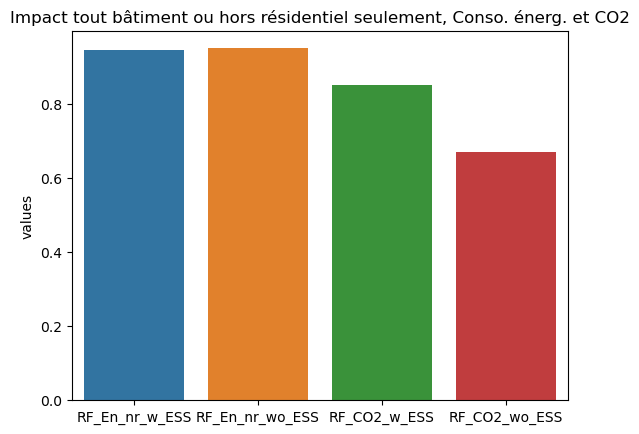

In [749]:
sns.barplot(data= df_rf_perf,x=df_rf_perf.index, y='values')
plt.title('Impact tout bâtiment ou hors résidentiel seulement, Conso. énerg. et CO2')
plt.show()

## Importance variable EnergyStarScore, "GHGEmissionsIntensity", non résidentiel.

In [732]:
X_nr_wo_y.drop('ENERGYSTARScore', axis=1, inplace=True)

In [733]:
X_nr_wo_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642 entries, 0 to 3344
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Latitude                         1642 non-null   float64
 1   Longitude                        1642 non-null   float64
 2   YearBuilt                        1642 non-null   int64  
 3   NumberofBuildings                1642 non-null   float64
 4   NumberofFloors                   1642 non-null   int64  
 5   PropertyGFAParking               1642 non-null   int64  
 6   PropertyGFABuilding(s)           1642 non-null   int64  
 7   LargestPropertyUseTypeGFA        1642 non-null   float64
 8   SecondLargestPropertyUseTypeGFA  1642 non-null   float64
 9   ThirdLargestPropertyUseTypeGFA   1642 non-null   float64
 10  SiteEUI(kBtu/sf)                 1642 non-null   float64
 11  SourceEUI(kBtu/sf)               1642 non-null   float64
 12  SiteEnergyUse(kBtu) 

In [734]:
X_nr_train, X_nr_test, y_nr_train, y_nr_test = train_test_split(X_nr_wo_y, y_scaled_T)

In [735]:
# Distinguer les formats "Num" et "Cat" pour X
numerical_features = X_wo_Y.select_dtypes(include=['float64']).columns.tolist()
categorical_features = X_wo_Y.select_dtypes(include="object").columns.tolist()

In [736]:
# Pipeline numérique features

numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                   RobustScaler())

In [737]:
# Pipeline categorical features

categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                     OneHotEncoder(categories='auto', 
                                                   handle_unknown='infrequent_if_exist',
                                                   sparse_output=False))

In [738]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                         (categorical_pipeline, categorical_features))

In [739]:
robust_scaler = RobustScaler()
y_reshaped = y.values.reshape(-1,1)
y_scaled_T = robust_scaler.fit_transform(y_reshaped)
print("Dimensions sur y: {}".format(y_scaled_T.shape))

Dimensions sur y: (1642, 1)


In [740]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0)

In [741]:
pipe_rf = make_pipeline(preprocessor, rf)

In [742]:
pipe_rf.fit(X_train, y_train.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore',
                                                   'SiteEUI(...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=0))])

In [743]:
pipe_rf.score(X_test, y_test.ravel())

0.6705059239564557

## Synthèse résultats RF, consommation énergie et émissions CO2, tout bâtiment et hors résidentiel uniquement, avec et sans variable "ENERGYSTARScore".

In [744]:
d = {'RF_En_nr_w_ESS':[0.945], 'RF_En_nr_wo_ESS': [0.949], 'RF_CO2_w_ESS':[0.85], 'RF_CO2_wo_ESS':[0.67]}
l=list(d.items())
print(l)

values=[element[1] for element in l]
arr= np.array(values)
print(arr.shape)

names=[element[0] for element in l]

df_rf_perf = pd.DataFrame(data=arr, index= names)
df_rf_perf.rename(columns={0:'values'}, inplace=True)

[('RF_En_nr_w_ESS', [0.945]), ('RF_En_nr_wo_ESS', [0.949]), ('RF_CO2_w_ESS', [0.85]), ('RF_CO2_wo_ESS', [0.67])]
(4, 1)


In [745]:
df_rf_perf

,values
RF_En_nr_w_ESS,0.945
RF_En_nr_wo_ESS,0.949
RF_CO2_w_ESS,0.850
RF_CO2_wo_ESS,0.670


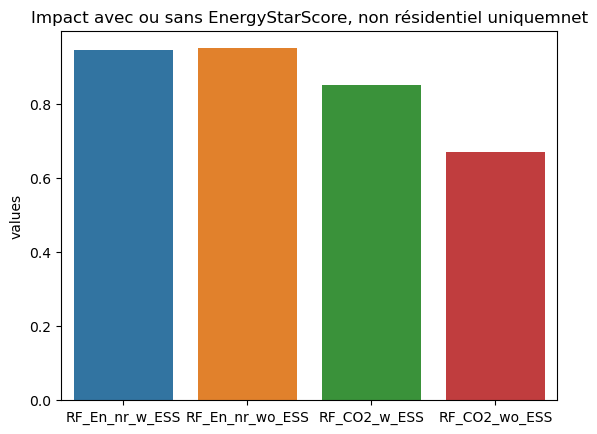

In [750]:
sns.barplot(data= df_rf_perf,x=df_rf_perf.index, y='values')
plt.title('Impact avec ou sans EnergyStarScore, non résidentiel uniquemnet')
plt.show()

Pour le set de données correspondant au non résidentiel uniquement, on observe un impact de la présence ou non de la variable EnergyStarScore. Faut il finalement inclure cette variable dans les analyses ? Cette variable est fabriquée à partir d'échantillons d'observations, ce n'est pas une variable "pure", elle est entachée d'erreur. Mon avis est que les analyses devraient se faire en excluant cette variable.